<a href="https://colab.research.google.com/github/xyzkpsf/OpenAi-Gym/blob/master/MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import time

In [ ]:
#Hypter_parameters, 200K Training
# Discount, exploration_decay_rate, K, Learning rate, linear space interval,last 1000 Training average scores
# Best so far: 0.9, e_rate=4, K=1, (0.9, 0.015), 40, 200k-> -114

In [5]:
# provides a default value for the key that does not exists.
Q = defaultdict(lambda: [0, 0, 0])
VISITED = defaultdict(lambda: [0, 0, 0])

env = gym.make("MountainCar-v0")

# Map state space into a linear space
def linear_state(state):
    pos, v = state
    pos_low, v_low = env.observation_space.low
    pos_high, v_high = env.observation_space.high

    a = 40 * (pos - pos_low) / (pos_high - pos_low)
    b = 40 * (v - v_low) / (v_high - v_low)

    return int(a), int(b)

# hyperparameter
discount = 0.9
EPOCHS = 250000
score_list = []
exploration_decay_rate = 4
K = 1   # Exploration function constant

for epoch in range(EPOCHS):
    # take some linear function map lr from 0.9 to about 0.015
    lr = 0.9 - (epoch/200000)/1.13
    state = linear_state(env.reset())
    score = 0
    exploration_rate = 0.01 + (1-0.01)*np.exp(-exploration_decay_rate * epoch / EPOCHS)

    if epoch > 200000:
      lr = 0.01
      exploration_rate = 0.01

    while True:
        action = np.argmax(Q[state])
        if np.random.random() <= exploration_rate:
            action = np.random.choice([0, 1, 2]) 

        next_s, reward, done, _ = env.step(action)
        if next_s[0] > 0.4:
            reward += 1
        next_s = linear_state(next_s)
        
        # Find the best action of S'
        optimal_next_a = -float('inf')
        for i in range(3):
            if Q[next_s][i] > optimal_next_a:
                optimal_next_a = i
        
        # Record the time that the (S', a') has been done
        VISITED[next_s][optimal_next_a] += 1
        
        Q[state][action] = (1 - lr) * Q[state][action] + lr * (reward + discount * (Q[next_s][optimal_next_a] + K / (VISITED[next_s][optimal_next_a] + 1)))
        score += reward
        state = next_s

        if done:
            score_list.append(score)
            if (epoch+1) % 10000 == 0:
                print('episode:', epoch, '; last 5000 score:', np.average((score_list[-5000:])), 'last 1000 score:', np.average((score_list[-1000:])), '; last 1000 max:', max((score_list[-1000:])))
            break
    ''''       
    if np.average((score_list[-1000:])) > -100:
        plt.plot(score_list)
        break
    '''        
env.close()

with open('MountainCar-v0-q-learning.pickle', 'wb') as f:
    pickle.dump(dict(Q), f)
    print('model saved')

episode: 9999 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0
episode: 19999 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0
episode: 29999 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0
episode: 39999 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0
episode: 49999 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0
episode: 59999 ; last 5000 score: -199.7484 last 1000 score: -199.626 ; last 1000 max: -159.0
episode: 69999 ; last 5000 score: -198.6958 last 1000 score: -198.171 ; last 1000 max: -153.0
episode: 79999 ; last 5000 score: -195.9848 last 1000 score: -195.845 ; last 1000 max: -149.0
episode: 89999 ; last 5000 score: -189.4714 last 1000 score: -187.04 ; last 1000 max: -144.0
episode: 99999 ; last 5000 score: -180.4454 last 1000 score: -180.193 ; last 1000 max: -146.0
episode: 109999 ; last 5000 score: -172.8402 last 1000 score: -173.263 ; last 1000 max:

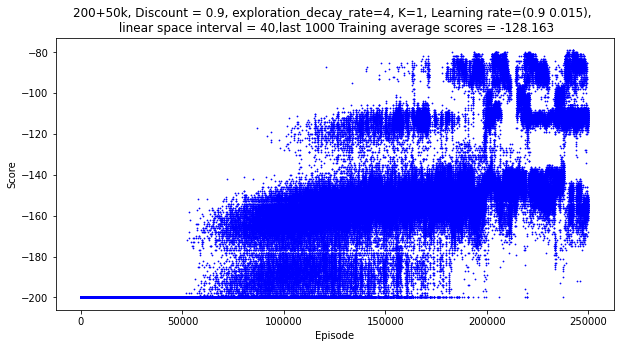

In [6]:
plt.figure(2, figsize=[10,5])
plt.plot(score_list,'b.',ms=1.5)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'200+50k, Discount = 0.9, exploration_decay_rate=4, K=1, Learning rate=(0.9 0.015), \n linear space interval = 40,last 1000 Training average scores = {np.average((score_list[-1000:]))}')
plt.savefig('250, 200+50k, Discount = 0.9, exploration_decay_rate=4, K=1, Learning rate=(0.9 0.015), linear space interval = 40.png')
plt.show()

Model loaded!
Average score: -135.14


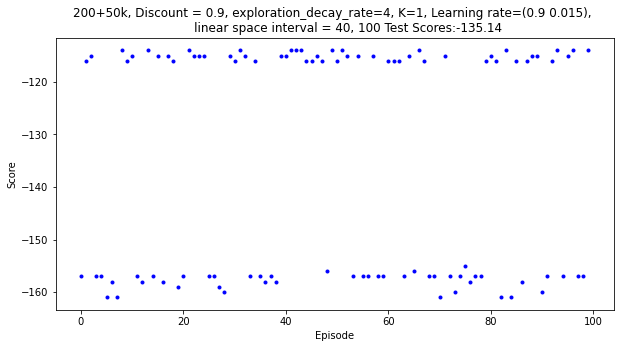

In [7]:
with open('MountainCar-v0-q-learning.pickle', 'rb') as f:
    Q = pickle.load(f)
    print("Model loaded!")

scores = []
env = gym.make('MountainCar-v0')


for _ in range(100):
    score = 0
    state = env.reset()
    while True:
        state = linear_state(state)
        action = np.argmax(Q[state]) if state in Q else np.random.choice([0, 1, 2])
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            scores.append(score)
            break
env.close()
print(f'Average score: {sum(scores)/len(scores)}')
plt.figure(2, figsize=[10,5])
plt.plot(scores, 'b.')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'200+50k, Discount = 0.9, exploration_decay_rate=4, K=1, Learning rate=(0.9 0.015), \n \
      linear space interval = 40, 100 Test Scores:{sum(scores)/len(scores)}')
plt.savefig('250, 200+50k, 0.9, e=4, K=1, Lr=(0.9 0.015),interval = 40.png')
plt.show()

In [ ]:
import gym
import numpy as np
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import time

episode: 0 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0
episode: 10000 ; last 5000 score: -200.0 last 1000 score: -200.0 ; last 1000 max: -200.0


KeyboardInterrupt: ignored

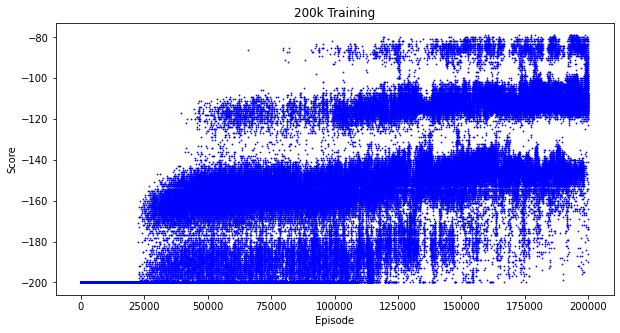

In [ ]:
plt.figure(2, figsize=[10,5])
plt.plot(score_list,'b.',ms=1.5)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title(f'400k Training')
plt.savefig('400k Training Scores.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
print( os.getcwd() )
print( os.listdir() )  

/content
['.config', '200k Training Scores.png', 'MountainCar-v0-q-learning.pickle', 'drive', 'sample_data']


In [ ]:
from google.colab import files
files.download( "200k Training Scores.png" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>